harmonic 3490177209.4540243 hits f12
q24 harmonic mirror hits neighbour_f01: 4009000000.0 of q25 at distance 0.0MHz
q25 harmonic mirror hits neighbour_f01: 3271000000.0 of q24 at distance 0.0MHz


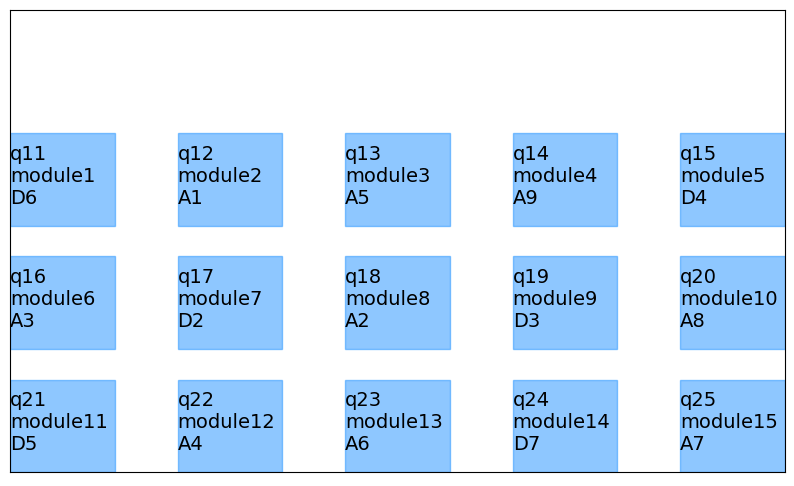

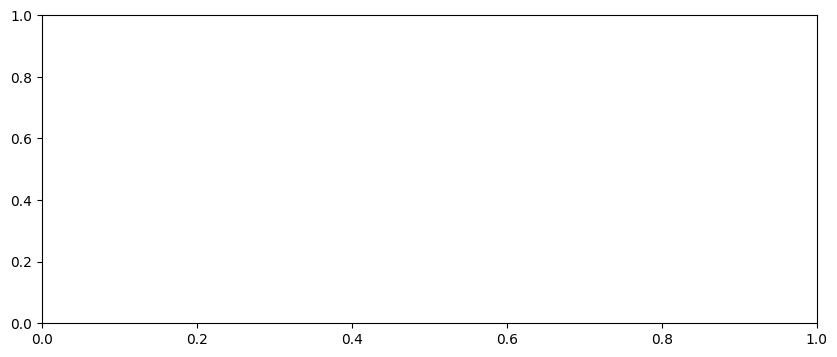

In [1]:
from coupler_mapping import create_coupler_marking
from utilities.QPU_connections_visualization import QPU

In [2]:
create_coupler_marking(QPU)

{'q11_q12': 1,
 'q12_q13': 2,
 'q11_q16': 4,
 'q16_q17': 2,
 'q16_q21': 3,
 'q21_q22': 1,
 'q17_q22': 4,
 'q22_q23': 2}

In [140]:
# !python reset_redis.py all

╔═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Qubits: 5                                                                                                                                             ║
║⮡ resonator_spectroscopy                                                                                                                               ║
║           ⮡ qubit_01_spectroscopy_pulsed                                                                                                              ║
║                         ⮡ rabi_oscillations                                                                                                           ║
║                                 ⮡ ramsey_correction                                                                                                   ║
║                                         ⮡ motzoi_parameter                

In [183]:
# !python reset_redis.py 'resonator_spectroscopy'
# !python reset_redis.py 'qubit_01_spectroscopy_pulsed'
# !python reset_redis.py 'rabi_oscillations'
# !python reset_redis.py 'motzoi_parameter''
# !python reset_redis.py 'n_rabi_oscillations'
# !python reset_redis.py 'resonator_spectroscopy_1'
# !python reset_redis.py 'qubit_12_spectroscopy_pulsed'
# !python reset_redis.py 'rabi_oscillations_12'
# !python reset_redis.py 'ramsey_correction_12'
# !python reset_redis.py 'resonator_spectroscopy_2'
!python reset_redis.py 'cz_chevron'

╔═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Qubits: 5                                                                                                                                             ║
║⮡ resonator_spectroscopy                                                                                                                               ║
║           ⮡ qubit_01_spectroscopy_pulsed                                                                                                              ║
║                         ⮡ rabi_oscillations                                                                                                           ║
║                                 ⮡ ramsey_correction                                                                                                   ║
║                                         ⮡ motzoi_parameter                

In [184]:
!python workers/calibration_supervisor.py

╔═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Qubits: 5                                                                                                                                             ║
║⮡ resonator_spectroscopy                                                                                                                               ║
║           ⮡ qubit_01_spectroscopy_pulsed                                                                                                              ║
║                         ⮡ rabi_oscillations                                                                                                           ║
║                                 ⮡ ramsey_correction                                                                                                   ║
║                                         ⮡ motzoi_parameter                

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
ds = load_dataset(r"data_directory/20231030/20231030-163637-214-3b6328-cz_chevron/dataset.hdf5")
ds

<xarray.Dataset>
Dimensions:                        (cz_pulse_amplitudesq11: 7,
                                    cz_pulse_amplitudesq12: 7,
                                    cz_pulse_amplitudesq13: 7,
                                    cz_pulse_amplitudesq14: 7,
                                    cz_pulse_amplitudesq15: 7,
                                    cz_pulse_frequencies_sweepq11: 5, ReIm: 2,
                                    cz_pulse_frequencies_sweepq12: 5,
                                    cz_pulse_frequencies_sweepq13: 5,
                                    cz_pulse_frequencies_sweepq14: 5,
                                    cz_pulse_frequencies_sweepq15: 5)
Coordinates:
  * cz_pulse_amplitudesq11         (cz_pulse_amplitudesq11) float64 0.0 ... 0...
  * cz_pulse_amplitudesq12         (cz_pulse_amplitudesq12) float64 0.0 ... 0...
  * cz_pulse_amplitudesq13         (cz_pulse_amplitudesq13) float64 0.0 ... 0...
  * cz_pulse_amplitudesq14         (cz_pulse_amplitudesq14) float64 0.0 ... 0...
  * cz_pulse_amplitudesq15         (cz_pulse_amplitudesq15) float64 0.0 ... 0...
  * cz_pulse_frequencies_sweepq11  (cz_pulse_frequencies_sweepq11) float64 -5...
  * cz_pulse_frequencies_sweepq12  (cz_pulse_frequencies_sweepq12) float64 -5...
  * cz_pulse_frequencies_sweepq13  (cz_pulse_frequencies_sweepq13) float64 -5...
  * cz_pulse_frequencies_sweepq14  (cz_pulse_frequencies_sweepq14) float64 -5...
  * cz_pulse_frequencies_sweepq15  (cz_pulse_frequencies_sweepq15) float64 -5...
Dimensions without coordinates: ReIm
Data variables:
    yq11_                          (cz_pulse_frequencies_sweepq11, cz_pulse_amplitudesq11, ReIm) float64 ...
    yq12_                          (cz_pulse_frequencies_sweepq12, cz_pulse_amplitudesq12, ReIm) float64 ...
    yq13_                          (cz_pulse_frequencies_sweepq13, cz_pulse_amplitudesq13, ReIm) float64 ...
    yq14_                          (cz_pulse_frequencies_sweepq14, cz_pulse_amplitudesq14, ReIm) float64 ...
    yq15_                          (cz_pulse_frequencies_sweepq15, cz_pulse_amplitudesq15, ReIm) float64 ...
Attributes:
    name:     cz_chevron
    tuid:     20231030-163637-214-3b6328-cz_chevron

In [43]:
import redis
redis_connection = redis.Redis(decode_responses=True)
couplers = ['q11_q12']
for coupler in couplers: 
    print(f"Coupler parameters {coupler}:")
    redis_config = redis_connection.hgetall(f"couplers:{coupler}")
    # Print the redis config line by line
    for key, value in redis_config.items():
        print(f"{key}: {value}")

Coupler parameters q11_q12:
ro_acq_delay: 2e-07
ro_freq: nan
ro_freq_1: nan
ro_freq_2: nan
ro_freq_opt: nan
ro_ampl_opt: nan
ro_pulse_amp_opt: nan
freq_01: nan
freq_12: nan
anharmonicity: nan
mw_amp180: nan
mw_motzoi: nan
mw_ef_amp180: nan
fidelity: nan
discriminator: nan
t1_time: nan
selectivity: nan
ro_ampl: nan
cz_pulse_frequency: nan
cz_pulse_amplitude: nan
cz_pulse_duration: nan
cz_pulse_width: nan
dc_flux: nan
dc_flux_offset: nan
dc_flux_0: nan
ro_pulse_delay: 4e-09
ro_pulse_duration: 3e-06
ro_acq_integration_time: 2.5e-06
mw_pulse_duration: 2e-08
init_duration: 0.0003
min_calibration_point: 0
max_calibration_point: 0
spec_pulse_duration: 5e-06
spec_amp: 0.0003
att: 0
artificial_detuning: 3000000.0


In [14]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q11','q12','q13','q14','q15']
# qubits = [ 'q15']
qubit_freq_01_list,qubit_freq_ro_list = {},{}
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    for key, value in redis_config.items():
        print(f"{key}: {value}")
    # print(f"mw_amp180: {redis_config['mw_amp180']}")

Qubit parameters q11:
ro_acq_delay: 2e-07
ro_freq: 6934489792.840477
ro_freq_1: 6934335589.10094
ro_freq_2: 6934149227.425686
ro_freq_opt: nan
ro_ampl_opt: nan
ro_pulse_amp_opt: nan
freq_01: 3714909311.9558687
freq_12: 3480498083.2063527
anharmonicity: nan
mw_amp180: 0.21904175817715849
mw_motzoi: -0.23333333333333334
mw_ef_amp180: 0.12059955295547596
fidelity: nan
discriminator: nan
t1_time: nan
selectivity: nan
ro_ampl: nan
ro_pulse_delay: 4e-09
ro_pulse_duration: 3e-06
ro_acq_integration_time: 2.5e-06
mw_pulse_duration: 2e-08
init_duration: 0.0003
min_calibration_point: 0
max_calibration_point: 0
spec_pulse_duration: 5e-06
spec_amp: 0.0003
att: 0
ro_pulse_amp: 0.02
artificial_detuning: 3000000.0
cz_pulse_frequency: nan
cz_pulse_amplitude: nan
cz_pulse_duration: nan
cz_pulse_width: nan
dc_flux: nan
dc_flux_0: nan
dc_flux_offset: nan
Qubit parameters q12:
ro_acq_delay: 2e-07
ro_freq: 6606599823.915397
ro_freq_1: 6606218132.222552
ro_freq_2: 6606624756.803857
ro_freq_opt: nan
ro_ampl_o

In [96]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q11','q12']
f01,f12 = [],[]
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")
    print(redis_config['freq_01'])
    print(redis_config['freq_12'])
    f01.append(redis_config['freq_01'])
    f12.append(redis_config['freq_12'])
f01,f12 = np.array(f01).astype(float),np.array(f12).astype(float)

Qubit parameters q11:
3714853914.3602576
3448909227.620381
Qubit parameters q12:
3366602683.94394
3366889792.3964834


In [158]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q11','q12','q13','q14','q15']
qubit_freq_01_list,qubit_freq_ro_list,qubit_freq_12_list = {},{},{}
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")
    print(redis_config['ro_freq'])
    print(redis_config['freq_01'])
    print(redis_config['freq_12'])
    qubit_freq_ro_list[qubit] = redis_config['ro_freq']
    qubit_freq_01_list[qubit] = redis_config['freq_01']
    qubit_freq_12_list[qubit] = redis_config['freq_12']

Qubit parameters q11:
6934516975.164495
3714911395.272988
3480219551.7001905
Qubit parameters q12:
6606536408.043257
3366876737.283394
3173925442.741397
Qubit parameters q13:
6688260738.410758
3584949401.0760307
3343692876.3960423
Qubit parameters q14:
6331293538.718747
3334050785.172637
3133039498.0560727
Qubit parameters q15:
6933733842.658668
3872848429.703217
3631777894.9530077


In [166]:
from config_files.VNA_values import VNA_resonator_frequencies, VNA_f01_frequencies, VNA_f12_frequencies
for qubit in qubits:
    VNA_resonator_frequencies[qubit] = float(qubit_freq_ro_list[qubit])
    VNA_f01_frequencies[qubit] = float(qubit_freq_01_list[qubit])
    VNA_f12_frequencies[qubit] = float(qubit_freq_12_list[qubit])
# rewrite the VNA_values.py file
with open('config_files/VNA_values.py', 'w') as f:
    f.write(f"VNA_resonator_frequencies = {VNA_resonator_frequencies}\n")
    f.write(f"VNA_f01_frequencies = {VNA_f01_frequencies}\n")
    f.write(f"VNA_f12_frequencies = {VNA_f12_frequencies}\n")

In [167]:
VNA_resonator_frequencies

{'q11': 6934516975.164495,
 'q12': 6606536408.043257,
 'q13': 6688260738.410758,
 'q14': 6331293538.718747,
 'q15': 6933733842.658668,
 'q16': 6491000000.0,
 'q17': 7059000000.0,
 'q18': 6712000000.0,
 'q19': 6818000000.0,
 'q20': 6494000000.0,
 'q21': 6751000000.0,
 'q22': 6477000000.0,
 'q23': 7052000000.0,
 'q24': 6583000000.0,
 'q25': 6853000000.0}

In [168]:
VNA_f01_frequencies

{'q11': 3714911395.272988,
 'q12': 3366876737.283394,
 'q13': 3584949401.0760307,
 'q14': 3334050785.172637,
 'q15': 3872848429.703217,
 'q16': 3189000000.0,
 'q17': 3932000000.0,
 'q18': 3254000000.0,
 'q19': 3921000000.0,
 'q20': 3333000000.0,
 'q21': 3773000000.0,
 'q22': 3326000000.0,
 'q23': 3911000000.0,
 'q24': 3271000000.0,
 'q25': 4009000000.0}

In [169]:
VNA_f12_frequencies

{'q11': 3480219551.7001905,
 'q12': 3173925442.741397,
 'q13': 3343692876.3960423,
 'q14': 3133039498.0560727,
 'q15': 3631777894.9530077,
 'q16': 2993000000.0,
 'q17': 3699000000.0,
 'q18': 3154000000.0,
 'q19': 3682000000.0,
 'q20': 3233000000.0,
 'q21': 3542000000.0,
 'q22': 3131000000.0,
 'q23': 3674000000.0,
 'q24': 3171000000.0,
 'q25': 3770000000.0}

In [165]:
# dict values to array
(np.array(list(VNA_f12_frequencies.values()))-np.array(list(VNA_f01_frequencies.values()))) / 1e6


array([-234.69184357, -192.95129454, -241.25652468, -201.01128712,
       -241.07053475, -196.        , -233.        , -100.        ,
       -239.        , -100.        , -231.        , -195.        ,
       -237.        , -100.        , -239.        ])

In [ ]:
VNA_resonator_frequencies = {'q11': 6934516975.164495, 'q12': 6606536408.043257, 'q13': 6688260738.410758, 'q14': 6331293538.718747, 'q15': 6933733842.658668, 'q16': 6491000000.0, 'q17': 7059000000.0, 'q18': 6712000000.0, 'q19': 6818000000.0, 'q20': 6494000000.0, 'q21': 6751000000.0, 'q22': 6477000000.0, 'q23': 7052000000.0, 'q24': 6583000000.0, 'q25': 6853000000.0}
VNA_f01_frequencies = {'q11': 3714911395.272988, 'q12': 3366876737.283394, 'q13': 3584949401.0760307, 'q14': 3334050785.172637, 'q15': 3872848429.703217, 'q16': 3189000000.0, 'q17': 3932000000.0, 'q18': 3254000000.0, 'q19': 3921000000.0, 'q20': 3333000000.0, 'q21': 3773000000.0, 'q22': 3326000000.0, 'q23': 3911000000.0, 'q24': 3271000000.0, 'q25': 4009000000.0}
VNA_f12_frequencies = {'q11': 3480219551.7001905, 'q12': 3173925442.741397, 'q13': 3343692876.3960423, 'q14': 3133039498.0560727, 'q15': 3631777894.9530077, 'q16': 2993000000.0, 'q17': 3699000000.0, 'q18': 3154000000.0, 'q19': 3682000000.0, 'q20': 3233000000.0, 'q21': 3542000000.0, 'q22': 3131000000.0, 'q23': 3674000000.0, 'q24': 3171000000.0, 'q25': 3770000000.0}
